In [1]:
import numpy as np
import pickle
import pandas as pd
import random
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef
from scipy import stats
import xgboost as xgb
#from hyperopt import fmin, tpe, hp, Trials, rand

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
plt.style.use('CCB_plot_style_0v4.mplstyle')
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   #fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000'] 


Bad key text.latex.preview in file CCB_plot_style_0v4.mplstyle, line 55 ('text.latex.preview  : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file CCB_plot_style_0v4.mplstyle, line 63 ('mathtext.fallback_to_cm : True ## When True, use symbols from the Computer Modern fonts')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [2]:
import warnings
from rdkit import RDLogger

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning,
                        message=".*Chem.MolFromInchi.*")
warnings.filterwarnings("ignore", category=UserWarning,
                        message=".*SettingWithCopyWarning.*")
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Suppress RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

## 1. Loading training, validation, and test data:

### (a) Loading data: 

In [3]:
sequences = ["MEKEDQEKTGKLTLVLALATFLAAFGSSFQYGYNVAAVNSPSEFMQQFYNDTYYDRNKENIESFTLTLLWSLTVSMFPFGGFIGSLMVGFLVNNLGRKGALLFNNIFSILPAILMGCSKIAKSFEIIIASRLLVGICAGISSNVVPMYLGELAPKNLRGALGVVPQLFITVGILVAQLFGLRSVLASEEGWPILLGLTGVPAGLQLLLLPFFPESPRYLLIQKKNESAAEKALQTLRGWKDVDMEMEEIRKEDEAEKAAGFISVWKLFRMQSLRWQLISTIVLMAGQQLSGVNAIYYYADQIYLSAGVKSNDVQYVTAGTGAVNVFMTMVTVFVVELWGRRNLLLIGFSTCLTACIVLTVALALQNTISWMPYVSIVCVIVYVIGHAVGPSPIPALFITEIFLQSSRPSAYMIGGSVHWLSNFIVGLIFPFIQVGLGPYSFIIFAIICLLTTIYIFMVVPETKGRTFVEINQIFAKKNKVSDVYPEKEEKELNDLPPATREQ",
            "MSNKQETKILGMPPFVVDFLMGGVSAAVSKTAAAPIERIKLLVQNQDEMIKAGRLDRRYNGIIDCFRRTTADEGLMALWRGNTANVIRYFPTQALNFAFRDKFKAMFGYKKDKDGYAKWMAGNLASGGAAGATSLLFVYSLDYARTRLANDAKSAKGGGARQFNGLIDVYRKTLASDGIAGLYRGFGPSVAGIVVYRGLYFGMYDSIKPVVLVGPLANNFLASFLLGWCVTTGAGIASYPLDTVRRRMMMTSGEAVKYKSSIDAFRQIIAKEGVKSLFKGAGANILRGVAGAGVLSIYDQLQILLFGKAFKGGSG",
            ]

data_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))
data_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

data_train = data_train.loc[~data_train["Sequence"].isin(sequences)]

data_train.reset_index(inplace = True, drop = True)
data_test.reset_index(inplace = True, drop = True)

len(data_train), len(data_test)

(26701, 6282)

In [4]:
'''df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_seq = pd.DataFrame({"Sequence" : df_train["Sequence"], "cluster" : df_train["cluster"]})
df_seq.drop_duplicates(inplace = True)
data_train = data_train.merge(df_seq, on = "Sequence", how = "left")
data_train.head()

all_clusters_train = list(set(data_train["cluster"]))
random.shuffle(all_clusters_train)
n = len(all_clusters_train)
k = int(n/5)
clusters_fold1, clusters_fold2, clusters_fold3 = all_clusters_train[:k], all_clusters_train[k:k*2], all_clusters_train[k*2:k*3]
clusters_fold4, clusters_fold5= all_clusters_train[k*3:4*k], all_clusters_train[4*k:]

fold_indices = [list(data_train.loc[data_train["cluster"].isin(clusters_fold1)].index),
                list(data_train.loc[data_train["cluster"].isin(clusters_fold2)].index),
                list(data_train.loc[data_train["cluster"].isin(clusters_fold3)].index),
                list(data_train.loc[data_train["cluster"].isin(clusters_fold4)].index),
                list(data_train.loc[data_train["cluster"].isin(clusters_fold5)].index)]



train_indices = [[], [], [], [], []]
test_indices = [[], [], [], [], []]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
            
    test_indices[i] = fold_indices[i]
    
    
np.save(join("..", "..", "data", "transporter_substrate_pairs", "splits", "CV_train_indices_SPOT.npy"), train_indices)
np.save(join("..", "..", "data", "transporter_substrate_pairs", "splits", "CV_test_indices_SPOT.npy"), test_indices)''';

In [5]:
train_indices = np.load(join("..", "..", "data", "transporter_substrate_pairs", "splits", "CV_train_indices_SPOT.npy"), allow_pickle = True)
test_indices = np.load(join("..", "..", "data", "transporter_substrate_pairs","splits", "CV_test_indices_SPOT.npy"), allow_pickle = True)

## 2. Input: ECFP /ESM-1b

### (a) Creating input and output arrays (ECFP /ESM-1b)

In [6]:
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b"][ind]
        ecfp = np.array(list(df["ECFP"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (int(df["outcome"][ind]), );

    return(X,y)

train_X, train_y =  create_input_and_output_data(df = data_train)
test_X, test_y =  create_input_and_output_data(df = data_test)


feature_names =  ["ECFP_" + str(i) for i in range(1024)]
feature_names = feature_names + ["ESM1b_" + str(i) for i in range(1280)]

train_X = np.array(train_X)
test_X  = np.array(test_X)

train_y = np.array(train_y)
test_y  = np.array(test_y)

### (b) hyperparameter optimization:

In [7]:
'''def cross_validation_neg_mcc_gradient_boosting(param):
    num_round = param["num_rounds"]
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    param['objective'] = 'binary:logistic'
    weights = np.array([param["weight"] if y == 0 else 1.0 for y in data_train["outcome"]])
    
    del param["num_rounds"]
    del param["weight"]
    
    acc = []
    mcc = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(np.array(train_X[train_index]), weight = weights[train_index],
                         label = np.array(train_y[train_index]))
        dvalid = xgb.DMatrix(np.array(train_X[test_index]))
        bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
        y_valid_pred = np.round(bst.predict(dvalid))
        validation_y = train_y[test_index]
    
        acc.append(np.mean(y_valid_pred == np.array(validation_y)))
        mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
        print(acc)
        print(mcc)
    return(-np.mean(mcc))

#Defining search space for hyperparameter optimization
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", [7,8,9,10,11,12]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 200, 400),
    "weight" : hp.uniform("weight", 0.00,0.33)}''';

Performing a random grid search:

In [8]:
'''trials = Trials()

best = fmin(fn = cross_validation_neg_mcc_gradient_boosting, space = space_gradient_boosting,
                algo = rand.suggest, max_evals = 2000, trials = trials)''';

### (c) Training and validating model

In [9]:
param = {'learning_rate': 0.27093305483481267,
         'max_delta_step': 3.2767682439803796,
         'max_depth': 12,
         'min_child_weight': 0.2885682036264081,
         'num_rounds': 155.7259319282595,
         'reg_alpha': 0.7491845522015184,
         'reg_lambda': 0.23666994423192977,
         'weight': 0.3097321347502892}



num_round = param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
param['objective'] = 'binary:logistic'
weights = np.array([param["weight"] if binding == 0 else 1.0 for binding in data_train["outcome"]])

del param["num_rounds"]
del param["weight"]

mcc = []
acc = []
roc_auc = []
for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(np.array(train_X[train_index]),
                     label = np.array(train_y[train_index]))
    dvalid = xgb.DMatrix(np.array(train_X[test_index]))
    bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
    y_valid_pred = np.round(bst.predict(dvalid))
    validation_y = train_y[test_index]

    acc.append(np.mean(y_valid_pred == np.array(validation_y)))
    roc_auc.append(roc_auc_score(np.array(validation_y), bst.predict(dvalid)))
    mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
    
print(acc, roc_auc, mcc)
acc_cv_esm1b_ecfp = acc
mcc_cv_esm1b_ecfp = mcc
roc_auc_cv_esm1b_ecfp = roc_auc

dtrain = xgb.DMatrix(np.array(train_X), weight = weights, label = np.array(train_y),
                feature_names= feature_names)
dtest = xgb.DMatrix(np.array(test_X), label = np.array(test_y),
                    feature_names= feature_names)

evallist = [(dtrain, "train"), (dtest, "test")]

bst = xgb.train(param,  dtrain, int(num_round))#, evallist)

y_test_pred = np.round(bst.predict(dtest))
acc_test_esm1b_ecfp = np.mean(y_test_pred == np.array(test_y))
roc_auc_test_esm1b_ecfp = roc_auc_score(np.array(test_y), bst.predict(dtest))
mcc_test_esm1b_ecfp = matthews_corrcoef(np.array(test_y), y_test_pred)
print("Accuracy on test set: %s, ROC-AUC score for test set: %s, MCC: %s"  % (acc_test_esm1b_ecfp,
                                                                              roc_auc_test_esm1b_ecfp,
                                                                              mcc_test_esm1b_ecfp))
data_test["y_pred_ECFP_ESM1b"] = bst.predict(dtest)

[0.9368856699430936, 0.936310867462109, 0.9398286511257222, 0.9390117841637379, 0.9384805945499587] [0.9735223662671435, 0.9699922062954985, 0.972990362653891, 0.9725467338892086, 0.9729768294059944] [0.8322441806880225, 0.8302922132723949, 0.8403397396537307, 0.8385771496411363, 0.8375242163692976]
Accuracy on test set: 0.9146768545049347, ROC-AUC score for test set: 0.9569968693552555, MCC: 0.7744407123740622


## 3. Input: ChemBERTa /ESM-1b

### (a) Creating input and output arrays

In [10]:
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b"][ind]
        ecfp = df["ChemBERTa"][ind]
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (int(df["outcome"][ind]), );

    return(X,y)

train_X, train_y =  create_input_and_output_data(df = data_train)
test_X, test_y =  create_input_and_output_data(df = data_test)


feature_names =  ["ECFP_" + str(i) for i in range(767)]
feature_names = feature_names + ["ESM1b_" + str(i) for i in range(1280)]

train_X = np.array(train_X)
test_X  = np.array(test_X)

train_y = np.array(train_y)
test_y  = np.array(test_y)

### (b) hyperparameter optimization:

In [11]:
'''def cross_validation_neg_mcc_gradient_boosting(param):
    num_round = param["num_rounds"]
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    param['objective'] = 'binary:logistic'
    weights = np.array([param["weight"] if y == 0 else 1.0 for y in data_train["outcome"]])
    
    del param["num_rounds"]
    del param["weight"]
    
    acc = []
    mcc = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(np.array(train_X[train_index]), weight = weights[train_index],
                         label = np.array(train_y[train_index]))
        dvalid = xgb.DMatrix(np.array(train_X[test_index]))
        bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
        y_valid_pred = np.round(bst.predict(dvalid))
        validation_y = train_y[test_index]
    
        acc.append(np.mean(y_valid_pred == np.array(validation_y)))
        mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
        print(acc)
        print(mcc)
    return(-np.mean(mcc))

#Defining search space for hyperparameter optimization
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", [7,8,9,10,11,12]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 200, 400),
    "weight" : hp.uniform("weight", 0.00,0.33)}''';

In [12]:
'''trials = Trials()

best = fmin(fn = cross_validation_neg_mcc_gradient_boosting, space = space_gradient_boosting,
                algo = rand.suggest, max_evals = 2000, trials = trials)''';

### (c) Training and validating model

In [13]:
param = {'learning_rate': 0.11211681842630247,
         'max_delta_step': 1.6131034337079901,
          'max_depth': 11,
           'min_child_weight': 4.7767365234160195,
            'num_rounds': 103.2995179203733,
             'reg_alpha': 1.061445251263431,
              'reg_lambda': 0.35852219441242894,
               'weight': 0.4063667356577428}


num_round = param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
param['objective'] = 'binary:logistic'
weights = np.array([param["weight"] if binding == 0 else 1.0 for binding in data_train["outcome"]])

del param["num_rounds"]
del param["weight"]

mcc = []
acc = []
roc_auc = []
for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(np.array(train_X[train_index]),
                     label = np.array(train_y[train_index]))
    dvalid = xgb.DMatrix(np.array(train_X[test_index]))
    bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
    y_valid_pred = np.round(bst.predict(dvalid))
    validation_y = train_y[test_index]

    acc.append(np.mean(y_valid_pred == np.array(validation_y)))
    roc_auc.append(roc_auc_score(np.array(validation_y), bst.predict(dvalid)))
    mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
    
print(acc, roc_auc, mcc)
acc_cv_esm1b_chemberta = acc
mcc_cv_esm1b_chemberta = mcc
roc_auc_cv_esm1b_chemberta = roc_auc

dtrain = xgb.DMatrix(np.array(train_X), weight = weights, label = np.array(train_y),
                feature_names= feature_names)
dtest = xgb.DMatrix(np.array(test_X), label = np.array(test_y),
                    feature_names= feature_names)

evallist = [(dtrain, "train"), (dtest, "test")]

bst = xgb.train(param,  dtrain, int(num_round),)# evallist)

y_test_pred = np.round(bst.predict(dtest))
acc_test_esm1b_chemberta = np.mean(y_test_pred == np.array(test_y))
roc_auc_test_esm1b_chemberta = roc_auc_score(np.array(test_y), bst.predict(dtest))
mcc_test_esm1b_chemberta = matthews_corrcoef(np.array(test_y), y_test_pred)
print("Accuracy on test set: %s, ROC-AUC score for test set: %s, MCC: %s"  % (acc_test_esm1b_chemberta,
                                                                              roc_auc_test_esm1b_chemberta,
                                                                              mcc_test_esm1b_chemberta))
data_test["y_pred_ChemBERTa_ESM1b"] = bst.predict(dtest)

[0.930850146576996, 0.9334085778781038, 0.9338513648137079, 0.9361174281579492, 0.9417836498761354] [0.9699569143314424, 0.972072807148811, 0.9727117234776975, 0.9715436239826564, 0.976313126768714] [0.8157083024510339, 0.8223748296091713, 0.8240376534353461, 0.8307835633295236, 0.8463392290118895]
Accuracy on test set: 0.9129258198026107, ROC-AUC score for test set: 0.9531907786369169, MCC: 0.7712411898041633


#### Production mode:

In [14]:
param = {'learning_rate': 0.11211681842630247,
         'max_delta_step': 1.6131034337079901,
          'max_depth': 11,
           'min_child_weight': 4.7767365234160195,
            'num_rounds': 103.2995179203733,
             'reg_alpha': 1.061445251263431,
              'reg_lambda': 0.35852219441242894,
               'weight': 0.4063667356577428}


num_round = param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
param['objective'] = 'binary:logistic'
weights = np.array([param["weight"] if binding == 0 else 1.0 for binding in 
                    list(data_train["outcome"]) + list(data_test["outcome"])])

del param["num_rounds"]
del param["weight"]

dtrain = xgb.DMatrix(np.concatenate([train_X, test_X]), weight = weights, label = np.concatenate([train_y, test_y]),
                feature_names= feature_names)
dtest = xgb.DMatrix(np.array(test_X), label = np.array(test_y),
                    feature_names= feature_names)

evallist = [(dtrain, "train"), (dtest, "test")]

bst = xgb.train(param,  dtrain, int(num_round))

y_test_pred = np.round(bst.predict(dtest))
acc_test_esm1b_chemberta = np.mean(y_test_pred == np.array(test_y))
roc_auc_test_esm1b_chemberta = roc_auc_score(np.array(test_y), bst.predict(dtest))
mcc_test_esm1b_chemberta = matthews_corrcoef(np.array(test_y), y_test_pred)
print("Accuracy on test set: %s, ROC-AUC score for test set: %s, MCC: %s"  % (acc_test_esm1b_chemberta,
                                                                              roc_auc_test_esm1b_chemberta,
                                                                              mcc_test_esm1b_chemberta))

#save model:
pickle.dump(bst, open(join("..", "..", "data", "xgboost_model_production_mode.dat"), "wb"))

Accuracy on test set: 0.9920407513530722, ROC-AUC score for test set: 0.9998287712893377, MCC: 0.9796832805500814


## 3. Input: ChemBERTa /ESM-1b_ts

### (a) Creating input and output arrays

In [15]:
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        ecfp = np.array(list(df["ChemBERTa"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (int(df["outcome"][ind]), );

    return(X,y)

train_X, train_y =  create_input_and_output_data(df = data_train)
test_X, test_y =  create_input_and_output_data(df = data_test)


feature_names =  ["ECFP_" + str(i) for i in range(767)]
feature_names = feature_names + ["ESM1b_" + str(i) for i in range(1280)]

train_X = np.array(train_X)
test_X  = np.array(test_X)

train_y = np.array(train_y)
test_y  = np.array(test_y)

### (b) hyperparameter optimization:

In [16]:
'''def cross_validation_neg_mcc_gradient_boosting(param):
    num_round = param["num_rounds"]
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    param['objective'] = 'binary:logistic'
    weights = np.array([param["weight"] if y == 0 else 1.0 for y in data_train["outcome"]])
    
    del param["num_rounds"]
    del param["weight"]
    
    acc = []
    mcc = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(np.array(train_X[train_index]), weight = weights[train_index],
                         label = np.array(train_y[train_index]))
        dvalid = xgb.DMatrix(np.array(train_X[test_index]))
        bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
        y_valid_pred = np.round(bst.predict(dvalid))
        validation_y = train_y[test_index]
    
        acc.append(np.mean(y_valid_pred == np.array(validation_y)))
        mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
        print(acc)
        print(mcc)
    return(-np.mean(mcc))

#Defining search space for hyperparameter optimization
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", [7,8,9,10,11,12]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 200, 400),
    "weight" : hp.uniform("weight", 0.00,0.33)}''';

Performing a random grid search:

In [17]:
'''trials = Trials()

best = fmin(fn = cross_validation_neg_mcc_gradient_boosting, space = space_gradient_boosting,
                algo = rand.suggest, max_evals = 2000, trials = trials)''';

### (c) Training and validating model

In [18]:
param = {'learning_rate': 0.3529495351679151,
         'max_delta_step': 2.807731336260235,
         'max_depth': 9,
         'min_child_weight': 1.0278675583399608,
         'num_rounds': 288.8214233876903,
         'reg_alpha': 0.025697406994433236,
         'reg_lambda': 1.4540684149025358,
         'weight': 0.3262212830421869}

num_round = param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
param['objective'] = 'binary:logistic'
weights = np.array([param["weight"] if binding == 0 else 1.0 for binding in data_train["outcome"]])



del param["num_rounds"]
del param["weight"]

mcc = []
acc = []
roc_auc = []
for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(np.array(train_X[train_index]),
                     label = np.array(train_y[train_index]))
    dvalid = xgb.DMatrix(np.array(train_X[test_index]))
    bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
    y_valid_pred = np.round(bst.predict(dvalid))
    validation_y = train_y[test_index]

    acc.append(np.mean(y_valid_pred == np.array(validation_y)))
    roc_auc.append(roc_auc_score(np.array(validation_y), bst.predict(dvalid)))
    mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
    
print(acc, roc_auc, mcc)
acc_cv_esm1b_ts_chemberta = acc
mcc_cv_esm1b_ts_chemberta = mcc
roc_auc_cv_esm1b_ts_chemberta = roc_auc

dtrain = xgb.DMatrix(np.array(train_X), weight = weights, label = np.array(train_y),
                feature_names= feature_names)
dtest = xgb.DMatrix(np.array(test_X), label = np.array(test_y),
                    feature_names= feature_names)

evallist = [(dtrain, "train"), (dtest, "test")]

bst = xgb.train(param,  dtrain, int(num_round))#, evallist)

y_test_pred = np.round(bst.predict(dtest))
acc_test_esm1b_ts_chemberta = np.mean(y_test_pred == np.array(test_y))
roc_auc_test_esm1b_ts_chemberta = roc_auc_score(np.array(test_y), bst.predict(dtest))
mcc_test_esm1b_ts_chemberta = matthews_corrcoef(np.array(test_y), y_test_pred)
print("Accuracy on test set: %s, ROC-AUC score for test set: %s, MCC: %s"  % (acc_test_esm1b_ts_chemberta,
                                                                              roc_auc_test_esm1b_ts_chemberta,
                                                                              mcc_test_esm1b_ts_chemberta))
data_test["y_pred_chemberta_esm1b_ts"] = bst.predict(dtest)

[0.9496464907742714, 0.9553369880683651, 0.9575612671846981, 0.96154641306595, 0.9620148637489678] [0.9850924019688179, 0.9888144427975267, 0.9884093942976456, 0.9890163009790511, 0.9900201086457914] [0.8673020518316431, 0.8818952206759663, 0.8881610100861252, 0.8990903083287809, 0.9006022795550853]
Accuracy on test set: 0.9173829990448902, ROC-AUC score for test set: 0.9592482244227114, MCC: 0.7867990556662554


## 5. Input: ECFP /ESM-1b_ts

### (a) Creating input and output arrays

In [19]:
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        ecfp = np.array(list(df["ECFP"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (int(df["outcome"][ind]), );

    return(X,y)

train_X, train_y =  create_input_and_output_data(df = data_train)
test_X, test_y =  create_input_and_output_data(df = data_test)


feature_names =  ["ECFP_" + str(i) for i in range(1024)]
feature_names = feature_names + ["ESM1b_" + str(i) for i in range(1280)]

train_X = np.array(train_X)
test_X  = np.array(test_X)

train_y = np.array(train_y)
test_y  = np.array(test_y)

### (b) hyperparameter optimization:

In [20]:
'''def cross_validation_neg_mcc_gradient_boosting(param):
    num_round = param["num_rounds"]
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    param['objective'] = 'binary:logistic'
    weights = np.array([param["weight"] if y == 0 else 1.0 for y in data_train["outcome"]])
    
    del param["num_rounds"]
    del param["weight"]
    
    acc = []
    mcc = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(np.array(train_X[train_index]), weight = weights[train_index],
                         label = np.array(train_y[train_index]))
        dvalid = xgb.DMatrix(np.array(train_X[test_index]))
        bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
        y_valid_pred = np.round(bst.predict(dvalid))
        validation_y = train_y[test_index]
    
        acc.append(np.mean(y_valid_pred == np.array(validation_y)))
        mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
        print(acc)
        print(mcc)
    return(-np.mean(mcc))

#Defining search space for hyperparameter optimization
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", [7,8,9,10,11,12]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 200, 400),
    "weight" : hp.uniform("weight", 0.00,0.33)}''';

In [21]:
'''trials = Trials()

best = fmin(fn = cross_validation_neg_mcc_gradient_boosting, space = space_gradient_boosting,
                algo = rand.suggest, max_evals = 2000, trials = trials)''';

### (c) Training and validating model

In [22]:
param = {'learning_rate': 0.38469669326473216,
         'max_delta_step': 1.3916449221275724,
         'max_depth': 13,
         'min_child_weight': 1.2505348658632713,
         'num_rounds': 289.98564856980886,
         'reg_alpha': 0.027205529650688454,
         'reg_lambda': 1.3723293809191506,
         'weight': 0.2776515876001598}

num_round = param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
param['objective'] = 'binary:logistic'
weights = np.array([param["weight"] if binding == 0 else 1.0 for binding in data_train["outcome"]])

del param["num_rounds"]
del param["weight"]

mcc = []
acc = []
roc_auc = []
for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(np.array(train_X[train_index]),
                     label = np.array(train_y[train_index]))
    dvalid = xgb.DMatrix(np.array(train_X[test_index]))
    bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
    y_valid_pred = np.round(bst.predict(dvalid))
    validation_y = train_y[test_index]

    acc.append(np.mean(y_valid_pred == np.array(validation_y)))
    roc_auc.append(roc_auc_score(np.array(validation_y), bst.predict(dvalid)))
    mcc.append(matthews_corrcoef(np.array(validation_y), y_valid_pred))
    
print(acc, roc_auc, mcc)
acc_cv_esm1b_ts_ecfp = acc
mcc_cv_esm1b_ts_ecfp = mcc
roc_auc_cv_esm1b_ts_ecfp = roc_auc

dtrain = xgb.DMatrix(np.array(train_X), weight = weights, label = np.array(train_y),
                feature_names= feature_names)
dtest = xgb.DMatrix(np.array(test_X), label = np.array(test_y),
                    feature_names= feature_names)

evallist = [(dtrain, "train"), (dtest, "test")]

bst = xgb.train(param,  dtrain, int(num_round))#, evallist)

y_test_pred = np.round(bst.predict(dtest))
acc_test_esm1b_ts_ecfp = np.mean(y_test_pred == np.array(test_y))
roc_auc_test_esm1b_ts_ecfp = roc_auc_score(np.array(test_y), bst.predict(dtest))
mcc_test_esm1b_ts_ecfp = matthews_corrcoef(np.array(test_y), y_test_pred)
print("Accuracy on test set: %s, ROC-AUC score for test set: %s, MCC: %s"  % (acc_test_esm1b_ts_ecfp,
                                                                              roc_auc_test_esm1b_ts_ecfp,
                                                                              mcc_test_esm1b_ts_ecfp))
data_test["y_pred_ECFP_esm1b_ts"] = bst.predict(dtest)

[0.9496464907742714, 0.9501773621412447, 0.9557680812910938, 0.9563779201984701, 0.958092485549133] [0.9849187018517499, 0.9858239218652346, 0.9880938233091316, 0.9890470943264476, 0.9886100995772729] [0.8672756181711028, 0.8681884515129941, 0.883416431141188, 0.8854102816836799, 0.8902575411824534]
Accuracy on test set: 0.898121617319325, ROC-AUC score for test set: 0.9469776225643143, MCC: 0.7374669698659859


## 6. Testing for statistical significance in model performance

In [23]:
df_test_pred = pd.read_csv(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test_with_pred.csv"))
data_test["y_pred_ChemBERTa_ESM1b"] = df_test_pred["pred"]

In [24]:
from statsmodels.stats.contingency_tables import mcnemar

def mc_nemar_test(y_true, y_pred1, y_pred2):
    n00, n01, n10, n11 = 0,0,0,0
    for i,y in enumerate(y_true):
        if y == y_pred1[i]:
            if y == y_pred2[i]:
                n11 +=1
            else:
                n10 +=1
        else:
            if y == y_pred2[i]:
                n01 +=1
            else:
                n00 +=1
    
    data = [[n00, n01],
        [n10, n11]]
    
    significance_value = 0.05

    # McNemar's Test with the continuity correction
    test = mcnemar(data, exact=False)   
    if test.pvalue < significance_value:
        print("Reject Null hypotesis. p-value = %d" % test.pvalue)
    else:
        print("Fail to reject Null hypotesis. p-value = %d" % test.pvalue)
    return(test)

In [25]:
test = mc_nemar_test(y_true = np.array(data_test["outcome"]),
              y_pred1 = np.round(np.array(data_test["y_pred_ECFP_ESM1b"])),
              y_pred2 = np.round(np.array(data_test["y_pred_ChemBERTa_ESM1b"])))
print(test.pvalue)

Reject Null hypotesis. p-value = 0
0.0007323990319616096


## 7. Visualizing results

Different sources:

In [26]:
df_transporter = pd.read_pickle(join("..", "..", "data", "Transporter_merged.pkl"))

data_test["Source"] = ""

UIDs = list(set(data_test["Uniprot ID"]))
for UID in UIDs:
    help_df = df_transporter.loc[df_transporter["Uniprot ID"] == UID]
    if np.mean(help_df["GOA"]) == 1:
        data_test["Source"].loc[data_test["Uniprot ID"] == UID] = "GOA"
    elif np.mean(help_df["TCDB"]) == 1:
        data_test["Source"].loc[data_test["Uniprot ID"] == UID] = "TCDB"
    elif np.mean(help_df["SWISS"]) == 1:
         data_test["Source"].loc[data_test["Uniprot ID"] == UID] = "UniProt"
            
            
for source in ["GOA", "UniProt"]:
    help_df = data_test.loc[data_test["Source"] == source]
    y_test_pred, test_y = np.array(help_df["y_pred_ChemBERTa_ESM1b"]), np.array(help_df["outcome"])
    mean_ident = np.mean(help_df["max_ident"])
    acc = np.mean(np.round(y_test_pred) == np.array(test_y))
    roc_auc = roc_auc_score(np.array(test_y), y_test_pred)
    mcc = matthews_corrcoef(np.array(test_y), np.round(y_test_pred))
    
    print(source, len(test_y), acc, roc_auc, mcc, mean_ident)

GOA 2237 0.8752793920429146 0.9078646660348018 0.6720705311400792 50.31676352257488
UniProt 3282 0.9643510054844607 0.9870091081216712 0.9061037329038797 67.27446678854356


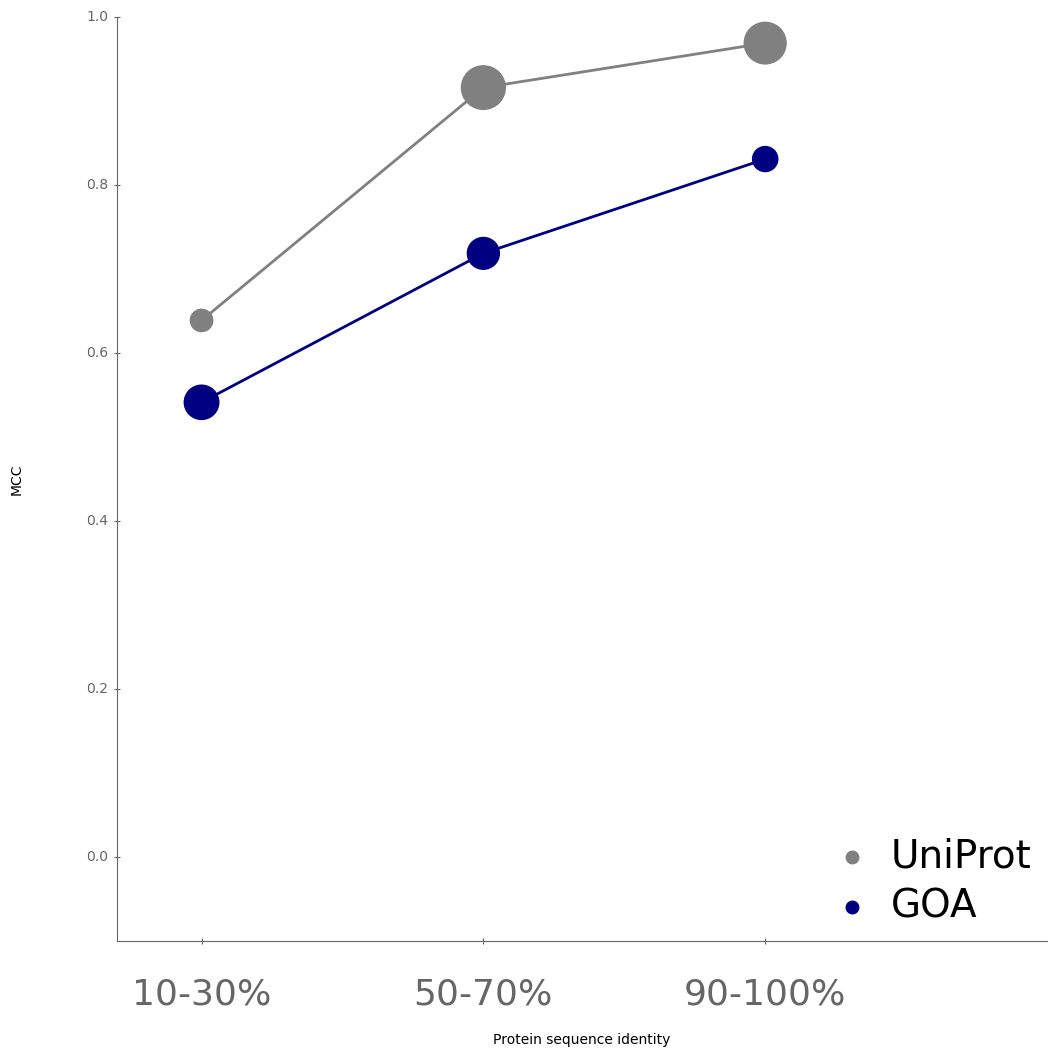

In [27]:
color_source = {"GOA": "navy", "TCDB" : "red", "UniProt" : "grey"}

splits = ["10-30%", "50-70%", "90-100%"]
lower_bound = [10,40,70]
upper_bound = [40,70,100]


fig, ax = plt.subplots(figsize= (12,12))
plt.rcParams.update({'font.size': 28})
for source in [  "UniProt",  "GOA"]:
    accuracies = []
    MCCs = []
    n_data_points = []
    for i, split in enumerate(splits):
        help_df = data_test.loc[data_test["Source"] == source]
        help_df = help_df.loc[help_df["max_ident"]> lower_bound[i]]
        help_df = help_df.loc[help_df["max_ident"]<= upper_bound[i]]
        y_true = np.array(help_df["outcome"])
        y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
        acc =  np.mean(y_pred == np.array(y_true))
        mcc = matthews_corrcoef(np.array(y_true), y_pred)
        accuracies.append(acc), MCCs.append(mcc)
        n_data_points.append(len(y_pred))

        if i ==0:
            plt.scatter(-1, MCCs[i], color =color_source[source], s=100, label = source)
            circle = plt.Circle((i/3, MCCs[i]), np.sqrt(len(help_df))/1500, color = color_source[source], fill = True)
            ax.add_artist(circle)

            #ax.annotate(n_data_points[i], (i-0.3, MCCs[i]-0.1), fontsize=20, c= color_source[source], weight = "bold")
        else:
            #ax.annotate(n_data_points[i], (i-0.38, MCCs[i]-0.1), fontsize=20, c= color_source[source], weight = "bold")
            circle = plt.Circle((i/3, MCCs[i]), np.sqrt(len(help_df))/1500, color = color_source[source], fill = True)
            ax.add_artist(circle)
            
    plt.plot(np.array(range(len(splits)))/3, MCCs, c= color_source[source], linewidth=2)



ticks2 = np.array(range(len(splits)))/3
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=5, rotation = 0)

plt.ylim((-0.1,1.))
plt.xlim((-0.1, 1.))

plt.ylabel('MCC')
plt.xlabel('Protein sequence identity')
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
plt.legend(loc = "lower right")
plt.savefig(join("..", "..", "figures", "MCC_for_different_sources.svg"))
plt.show()

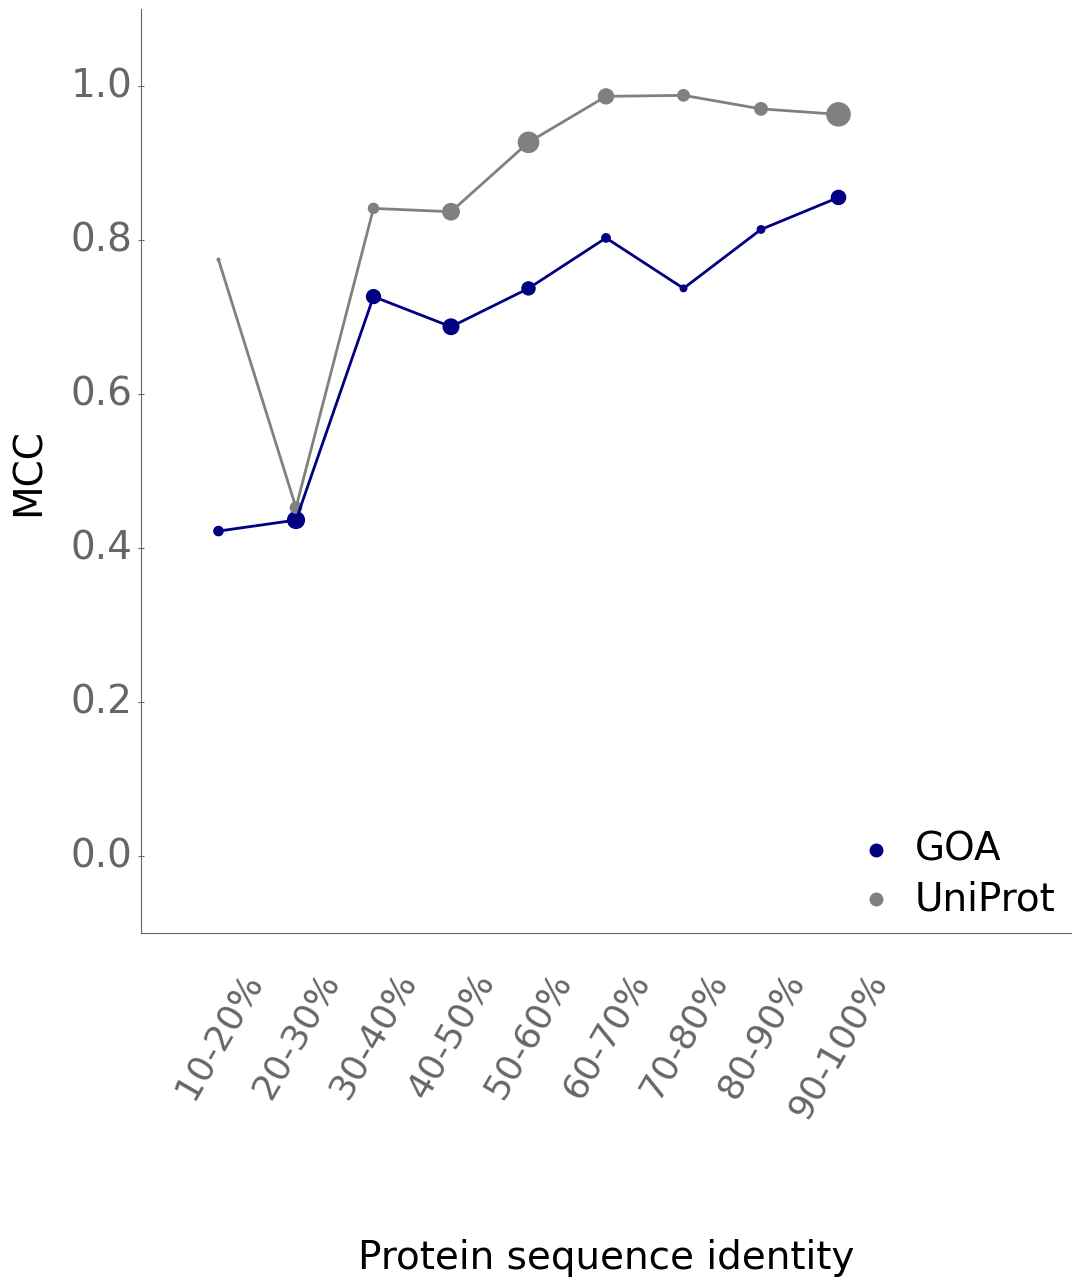

In [28]:
splits = ["10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
lower_bound = [10,20,30,40,50,60,70,80,90]
upper_bound = [20,30,40,50,60,70,80,90,100]


fig, ax = plt.subplots(figsize= (12,12))
plt.rcParams.update({'font.size': 28})
for source in ["GOA", "UniProt"]:
    accuracies = []
    MCCs = []
    n_data_points = []
    for i, split in enumerate(splits):
        help_df = data_test.loc[data_test["Source"] == source]
        help_df = help_df.loc[help_df["max_ident"]> lower_bound[i]]
        help_df = help_df.loc[help_df["max_ident"]<= upper_bound[i]]
        y_true = np.array(help_df["outcome"])
        y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
        acc =  np.mean(y_pred == np.array(y_true))
        mcc = matthews_corrcoef(np.array(y_true), y_pred)
        accuracies.append(acc), MCCs.append(mcc)
        n_data_points.append(len(y_pred))



        if i ==0:
            plt.scatter(-1, MCCs[i], color =color_source[source], s=100, label = source)
            circle = plt.Circle((i/10, MCCs[i]), np.sqrt(len(help_df))/2000, color = color_source[source], fill = True)
            ax.add_artist(circle)

            #ax.annotate(n_data_points[i], (i-0.3, MCCs[i]-0.1), fontsize=20, c= color_source[source], weight = "bold")
        else:
            #ax.annotate(n_data_points[i], (i-0.38, MCCs[i]-0.1), fontsize=20, c= color_source[source], weight = "bold")
            circle = plt.Circle((i/10, MCCs[i]), np.sqrt(len(help_df))/2000, color = color_source[source], fill = True)
            ax.add_artist(circle)

    plt.plot(np.array(range(len(splits)))/10, MCCs, c= color_source[source], linewidth=2)

ticks2 = np.array(range(len(splits)))/10
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 60)

plt.ylim((-0.1,1.1))
plt.xlim((-0.1, 1.1))

plt.ylabel('MCC')
plt.xlabel('Protein sequence identity')
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.xaxis.set_label_coords(0.5,-0.33)
plt.legend(loc = "lower right")
plt.show()

ROC curves:

In [29]:
from sklearn import metrics

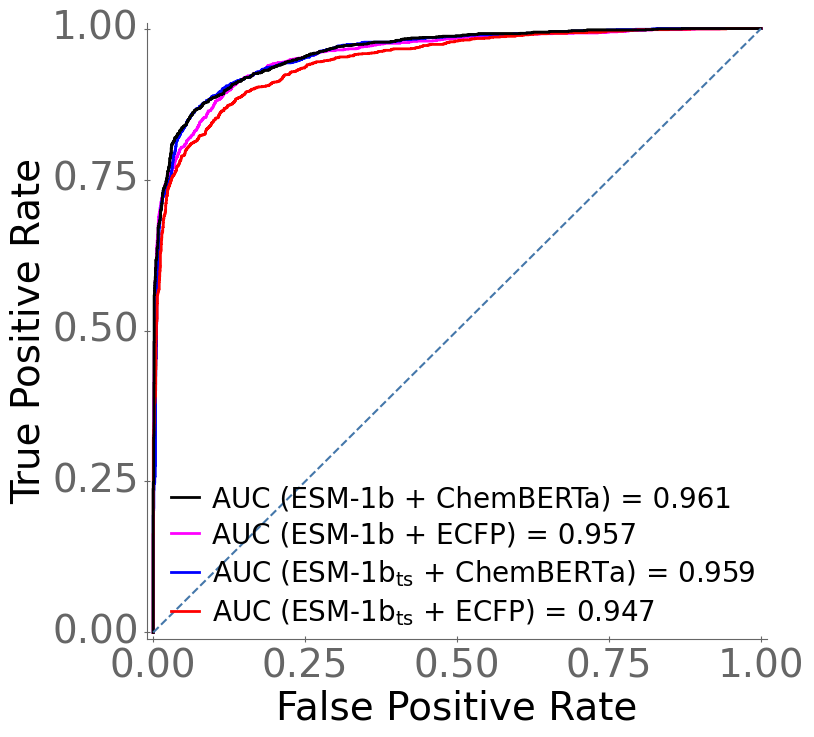

In [30]:
y_test_pred_esm1b_ecfp =  np.array(data_test["y_pred_ECFP_ESM1b"])
test_y_esm1b_ecfp =  np.array(data_test["outcome"])

y_test_pred_esm1b_ts_ecfp =  np.array(data_test["y_pred_ECFP_esm1b_ts"])
test_y_esm1b_ts_ecfp =  np.array(data_test["outcome"])

y_test_pred_esm1b_chemberta =  np.array(data_test["y_pred_ChemBERTa_ESM1b"])
test_y_esm1b_chemberta =  np.array(data_test["outcome"])

y_test_pred_esm1b_ts_chemberta =  np.array(data_test["y_pred_chemberta_esm1b_ts"])
test_y_esm1b_ts_chemberta =  np.array(data_test["outcome"])


fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

fpr_esm1b_ecfp, tpr_esm1b_ecfp, threshold = metrics.roc_curve(test_y_esm1b_ecfp, y_test_pred_esm1b_ecfp)
roc_auc_esm1b_ecfp = metrics.auc(fpr_esm1b_ecfp, tpr_esm1b_ecfp)

fpr_esm1b_ts_ecfp, tpr_esm1b_ts_ecfp, threshold = metrics.roc_curve(test_y_esm1b_ts_ecfp, y_test_pred_esm1b_ts_ecfp)
roc_auc_esm1b_ts_ecfp = metrics.auc(fpr_esm1b_ts_ecfp, tpr_esm1b_ts_ecfp)


fpr_esm1b_chemberta, tpr_esm1b_chemberta, threshold = metrics.roc_curve(test_y_esm1b_chemberta, y_test_pred_esm1b_chemberta)
roc_auc_esm1b_chemberta = metrics.auc(fpr_esm1b_chemberta, tpr_esm1b_chemberta)

fpr_esm1b_ts_chemberta, tpr_esm1b_ts_chemberta, threshold = metrics.roc_curve(test_y_esm1b_ts_chemberta, y_test_pred_esm1b_ts_chemberta)
roc_auc_esm1b_ts_chemberta = metrics.auc(fpr_esm1b_ts_chemberta, tpr_esm1b_ts_chemberta)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr_esm1b_chemberta, tpr_esm1b_chemberta, 'black', label = 'AUC (ESM-1b + ChemBERTa) = %0.3f' % roc_auc_esm1b_chemberta, linewidth=2.0)
plt.plot(fpr_esm1b_ecfp, tpr_esm1b_ecfp, 'magenta', label = 'AUC (ESM-1b + ECFP) = %0.3f' % roc_auc_esm1b_ecfp, linewidth=2.0)
plt.plot(fpr_esm1b_ts_chemberta, tpr_esm1b_ts_chemberta, 'blue', label = 'AUC (ESM-$1b_{ts}$ + ChemBERTa) = %0.3f' % roc_auc_esm1b_ts_chemberta, linewidth=2.0)
plt.plot(fpr_esm1b_ts_ecfp, tpr_esm1b_ts_ecfp, 'red', label = 'AUC (ESM-$1b_{ts}$ + ECFP) = %0.3f' % roc_auc_esm1b_ts_ecfp, linewidth=2.0)
plt.plot(fpr_esm1b_chemberta, tpr_esm1b_chemberta, 'black', linewidth=2.0)



ax.locator_params(axis="y", nbins=5)
ax.locator_params(axis="x", nbins=5)

plt.legend(loc = 'lower right', fontsize =20)
plt.plot([0, 1], [0, 1],'--')
eps = 0.01
plt.xlim([0-eps, 1+eps])
plt.ylim([0-eps, 1+eps])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig(join("..", "..", "figures", "ROC_curves.png"))
plt.show()

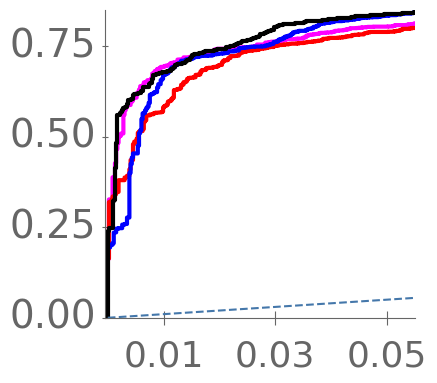

In [31]:
fig, ax = plt.subplots(figsize= (4,4))
plt.rcParams.update({'font.size': 28})

fpr_esm1b_ecfp, tpr_esm1b_ecfp, threshold = metrics.roc_curve(test_y_esm1b_ecfp, y_test_pred_esm1b_ecfp)
roc_auc_esm1b_ecfp = metrics.auc(fpr_esm1b_ecfp, tpr_esm1b_ecfp)

fpr_esm1b_ts_ecfp, tpr_esm1b_ts_ecfp, threshold = metrics.roc_curve(test_y_esm1b_ts_ecfp, y_test_pred_esm1b_ts_ecfp)
roc_auc_esm1b_ts_ecfp = metrics.auc(fpr_esm1b_ts_ecfp, tpr_esm1b_ts_ecfp)


fpr_esm1b_chemberta, tpr_esm1b_chemberta, threshold = metrics.roc_curve(test_y_esm1b_chemberta, y_test_pred_esm1b_chemberta)
roc_auc_esm1b_chemberta = metrics.auc(fpr_esm1b_chemberta, tpr_esm1b_chemberta)

fpr_esm1b_ts_chemberta, tpr_esm1b_ts_chemberta, threshold = metrics.roc_curve(test_y_esm1b_ts_chemberta, y_test_pred_esm1b_ts_chemberta)
roc_auc_esm1b_ts_chemberta = metrics.auc(fpr_esm1b_ts_chemberta, tpr_esm1b_ts_chemberta)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr_esm1b_ecfp, tpr_esm1b_ecfp, 'magenta', label = 'AUC (ESM-1b/ECFP) = %0.3f' % roc_auc_esm1b_ecfp, linewidth=3.0)
plt.plot(fpr_esm1b_ts_ecfp, tpr_esm1b_ts_ecfp, 'red', label = 'AUC (ESM-$1b_{ts}$/ECFP) = %0.3f' % roc_auc_esm1b_ts_ecfp, linewidth=3.0)

plt.plot(fpr_esm1b_ts_chemberta, tpr_esm1b_ts_chemberta, 'blue', label = 'AUC (ESM-$1b_{ts}$/chemberta) = %0.3f' % roc_auc_esm1b_ts_chemberta, linewidth=3.0)
plt.plot(fpr_esm1b_chemberta, tpr_esm1b_chemberta, 'black', label = 'AUC (ESM-1b/chemberta) = %0.3f' % roc_auc_esm1b_chemberta, linewidth=3.0)



ticks2 = np.array([0.01,0.03, 0.05])
labs = [ "0.01", "0.03", "0.05"]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=10, rotation = 0)


plt.plot([0, 1], [0, 1],'--')
eps = 0.5*1e-3
plt.xlim([0-eps, 0.055])
plt.ylim([0-eps, 0.85])#1+eps])
ax.locator_params(axis="y", nbins=4)
#ax.locator_params(axis="x", nbins=3)
plt.savefig(join("..", "..", "figures", "ROC_curves_inset.png"))

plt.show()

Plotting prediction distribution:

In [32]:
y_test_pred = np.array(data_test["y_pred_ChemBERTa_ESM1b"])
test_y = np.array(data_test["outcome"])
wrong_predictions = [np.round(y_test_pred[i]) != test_y[i] for i in range(len(test_y))]

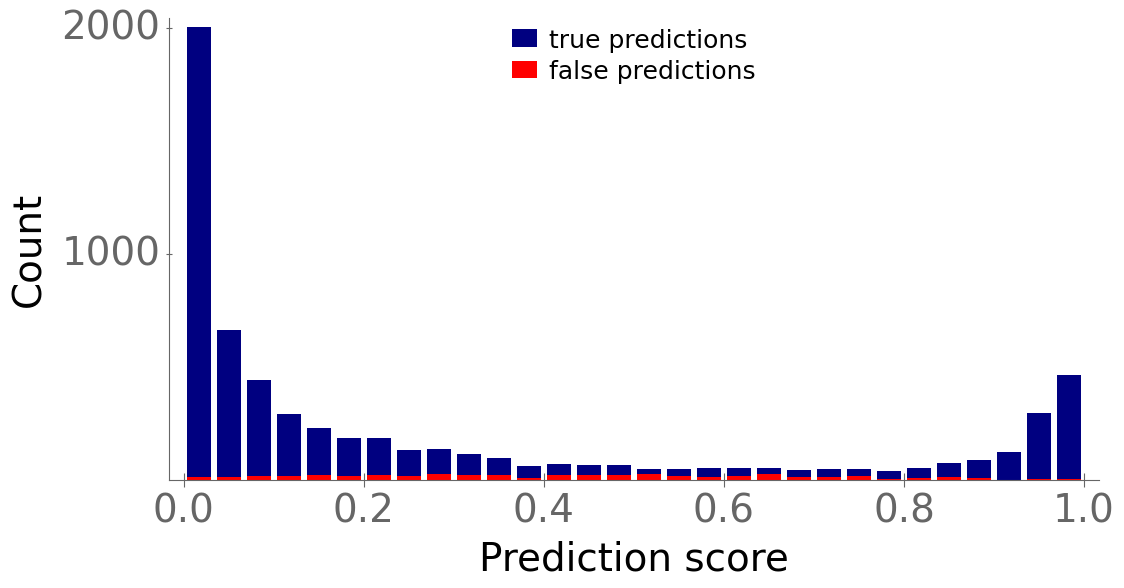

In [33]:

plt.rcParams.update({'font.size': 28})

#plt.rc('font', **font)

fig, ax = plt.subplots(figsize= (12,6))
#plt.title("Distribution of predicted probabilities", fontsize= 30, y= 1)
y_test_wrong = list(y_test_pred[wrong_predictions])
y_test_pred_copy =list(y_test_pred.copy())
y_test_wrong.append(0), y_test_pred_copy.append(0) ,y_test_wrong.append(1), y_test_pred_copy.append(1)

plt.hist(y_test_pred_copy, density = False, bins= 30, rwidth = 0.8, color= "navy", label = "true predictions")
plt.hist(y_test_wrong, density = False, bins= 30, rwidth = 0.8, color= "red", label = "false predictions")


plt.xlabel('Prediction score')
plt.ylabel('Count')
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

ticks1 = [1000,2000]
ax.set_yticks(ticks1)
ax.set_yticklabels(["1000", "2000"])
ax.tick_params(axis='x', which="major", length=10)

plt.legend(loc = "upper center", fontsize=18)
plt.savefig(join("..", "..", "figures", "hist_predicted_values.png"))
plt.show()

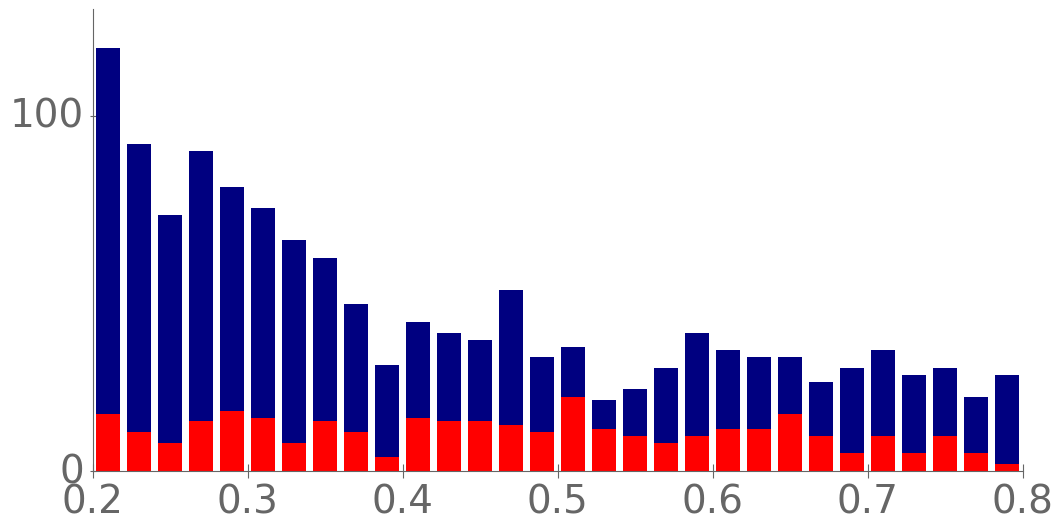

In [34]:
select = [list(wrong_predictions)[i] and list(y_test_pred<0.8)[i] and list(y_test_pred >0.2)[i] for i in range(len(wrong_predictions))]
y_test_wrong = list(y_test_pred[select])
select = [list(y_test_pred<0.8)[i] and list(y_test_pred >0.2)[i] for i in range(len(y_test_pred))]
y_test_pred_subset = list(y_test_pred[select])
y_test_wrong.append(0.2), y_test_pred_subset.append(0.2) ,y_test_wrong.append(0.8), y_test_pred_subset.append(0.8)

plt.rcParams.update({'font.size': 28})

#plt.rc('font', **font)

fig, ax = plt.subplots(figsize= (12,6))
#plt.title("Distribution of predicted probabilities", fontsize= 30, y= 1)

plt.hist(y_test_pred_subset, density = False, bins= 30, rwidth = 0.8, color= "navy", label = "true predictions")
plt.hist(y_test_wrong, density = False, bins= 30, rwidth = 0.8, color= "red", label = "false predictions")

ax.xaxis.set_label_coords(0.5,-0.13)
ax.tick_params(axis='x', which="major", length=10)

ticks1 = [0,100]
ax.set_yticks(ticks1)
ax.set_yticklabels(["0", "100"])

plt.xlim([0.2, 0.80])
plt.ylim([0, 130])
#ax.get_yaxis().set_visible(False)
plt.savefig(join("..", "..", "figures", "hist_predicted_values_inset.png"))
plt.show()



In [35]:
high_confidence = np.bitwise_or(y_test_pred <0.4, y_test_pred >0.6)
np.mean(high_confidence), np.mean(np.round(y_test_pred[high_confidence]) == test_y[high_confidence])

(0.9447628143903215, 0.9420387531592249)

In [36]:
1- np.mean(high_confidence), np.mean(np.round(y_test_pred[~ high_confidence]) == test_y[~ high_confidence])

(0.055237185609678496, 0.6311239193083573)

10 20 0.8197674418604651 0.4669611131375445
20 30 0.803921568627451 0.4407555455802751
30 40 0.889273356401384 0.7084323561254482
40 50 0.8985355648535565 0.7355907068984188
50 60 0.95274831243973 0.8749101790965287
60 70 0.9777327935222672 0.9430508492487926
70 80 0.9580645161290322 0.8960075346762385
80 90 0.9716157205240175 0.9280265352828485
90 100 0.9654510556621881 0.9114742535206376


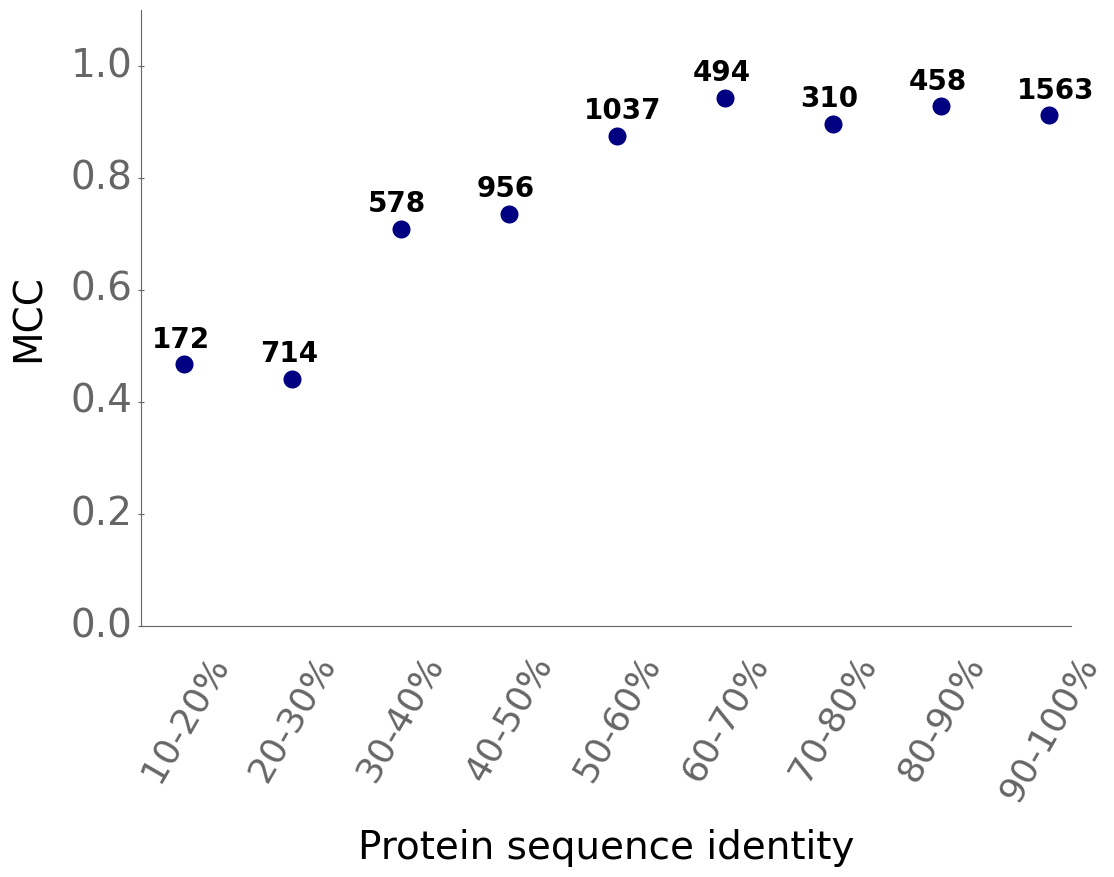

In [37]:
fig, ax = plt.subplots(figsize= (12,8))
plt.rcParams.update({'font.size': 28})

splits = ["10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
lower_bound = [10,20,30,40,50,60,70,80,90]
upper_bound = [20,30,40,50,60,70,80,90,100]

accuracies = []
MCCs = []
n_data_points = []
for i, split in enumerate(splits):
    
    help_df = data_test.loc[data_test["max_ident"]> lower_bound[i]]
    help_df = help_df.loc[help_df["max_ident"]<= upper_bound[i]]
    y_true = np.array(help_df["outcome"])
    y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
    acc =  np.mean(y_pred == np.array(y_true))
    mcc = matthews_corrcoef(np.array(y_true), y_pred)
    accuracies.append(acc), MCCs.append(mcc)
    n_data_points.append(len(y_pred))
    print(lower_bound[i], upper_bound[i], acc, mcc)
    
sub_bins = list(range(9))
    
#plt.bar(sub_bins, height = MCCs,  color= "navy")


for i in range(9):
    plt.scatter(i, MCCs[i], c='navy', marker="o", linewidths= 8, label ="KCATpred")
    ax.annotate(n_data_points[i], (i-0.3, MCCs[i]+0.03), fontsize=20, c= "black", weight = "bold")
  




ticks2 = np.array(range(len(splits)))
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 60)

plt.ylim((0.0,1.1))
plt.xlim((-0.4, 8.2))

plt.ylabel('MCC')
plt.xlabel('Protein sequence identity')
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.xaxis.set_label_coords(0.5,-0.33)

plt.savefig(join("..", "..", "figures", "MCC_prot_seq_ident.png"))
plt.show()

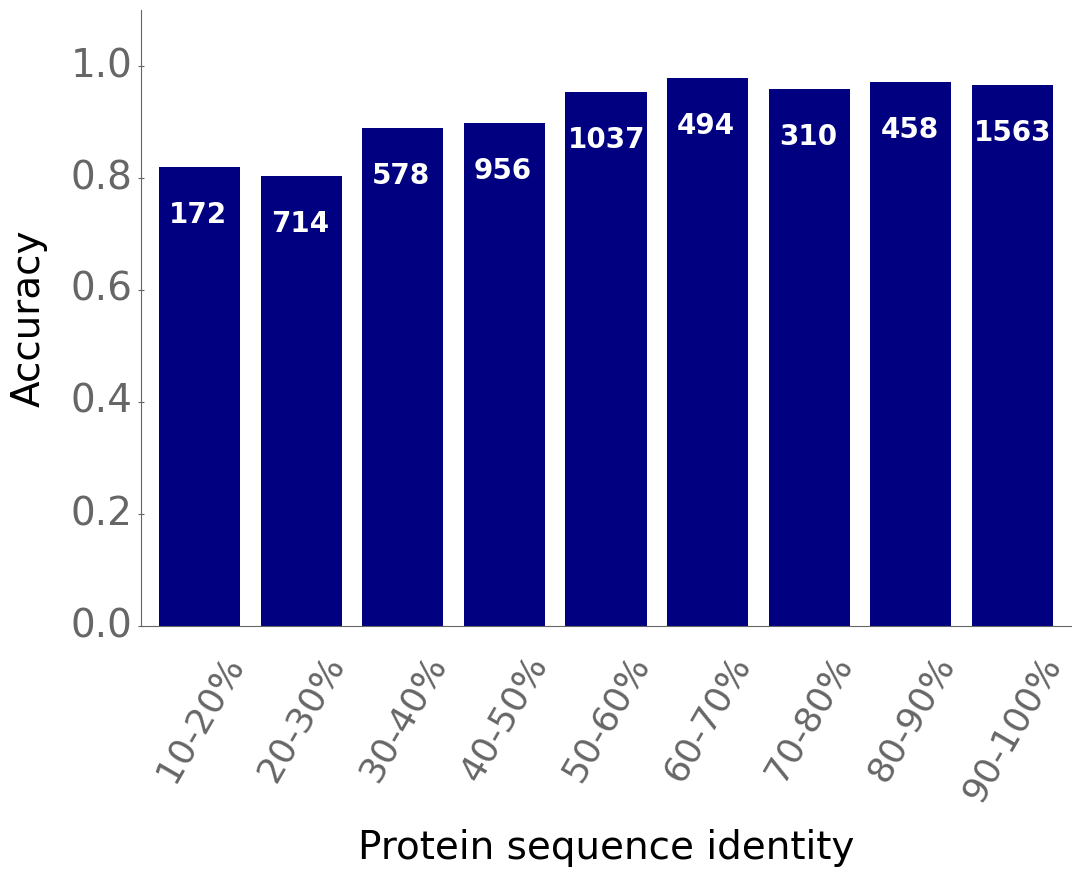

In [38]:
fig, ax = plt.subplots(figsize= (12,8))
plt.rcParams.update({'font.size': 28})

splits = ["10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
lower_bound = [10,20,30,40,50,60,70,80,90]
upper_bound = [20,30,40,50,60,70,80,90,100]

accuracies = []
MCCs = []
n_data_points = []
for i, split in enumerate(splits):
    
    help_df = data_test.loc[data_test["max_ident"]> lower_bound[i]]
    help_df = help_df.loc[help_df["max_ident"]<= upper_bound[i]]
    y_true = np.array(help_df["outcome"])
    y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
    acc =  np.mean(y_pred == np.array(y_true))
    mcc = matthews_corrcoef(np.array(y_true), y_pred)
    accuracies.append(acc), MCCs.append(mcc)
    n_data_points.append(len(y_pred))
    
sub_bins = list(range(9))
    
plt.bar(sub_bins, height = accuracies,  color= "navy")

for i in range(9):
    if n_data_points[i]<1000:
        ax.annotate(n_data_points[i], (i-0.3, accuracies[i]-0.1), fontsize=20, c= "white", weight = "bold")
    else:
        ax.annotate(n_data_points[i], (i-0.38, accuracies[i]-0.1), fontsize=20, c= "white", weight = "bold")


ticks2 = np.array(range(len(splits)))
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 60)

plt.ylim((0.0,1.1))
#plt.xlim((-0.2, 9.6))
plt.ylabel('Accuracy')
plt.xlabel('Protein sequence identity')
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.xaxis.set_label_coords(0.5,-0.33)
plt.savefig(join("..", "..", "figures", "Acc_prot_seq_ident.png"))
plt.show()

In [39]:
help_df = data_test.loc[data_test["max_ident"]> 0]
help_df = help_df.loc[help_df["max_ident"]< 40]
y_true = np.array(help_df["outcome"])
y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
acc =  np.mean(y_pred == np.array(y_true))
mcc = matthews_corrcoef(np.array(y_true), y_pred)

acc, mcc, len(y_pred)

(0.8394808743169399, 0.5558206139717631, 1464)

In [40]:
help_df = data_test.loc[data_test["max_ident"]> 50]
y_true = np.array(help_df["outcome"])
y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
acc =  np.mean(y_pred == np.array(y_true))
mcc = matthews_corrcoef(np.array(y_true), y_pred)

acc, mcc, len(y_pred)

(0.9637493526670119, 0.9060829188348947, 3862)

In [41]:
data_test["sub_train_count"] = np.nan

train_subs = list(data_train["molecule ID"].loc[data_train["outcome"] == 1])
for ind in data_test.index:
    sub = data_test["molecule ID"][ind]
    data_test["sub_train_count"][ind] = sum([sub == train_sub for train_sub in train_subs])

0 0.6098277916439723 166
1 0.8432740427115678 52
2 0.5753302987899386 113
3 0.7096984207774162 145
4 0.4666666666666667 120
5 0.6491488427365055 155
6 0.6895881216357783 118
7 0.5493292425938898 211
8 0.5952791366544385 92
9 0.7408876433940658 54
10 0.7601448751117506 77
>10 0.9395460935930909 4979


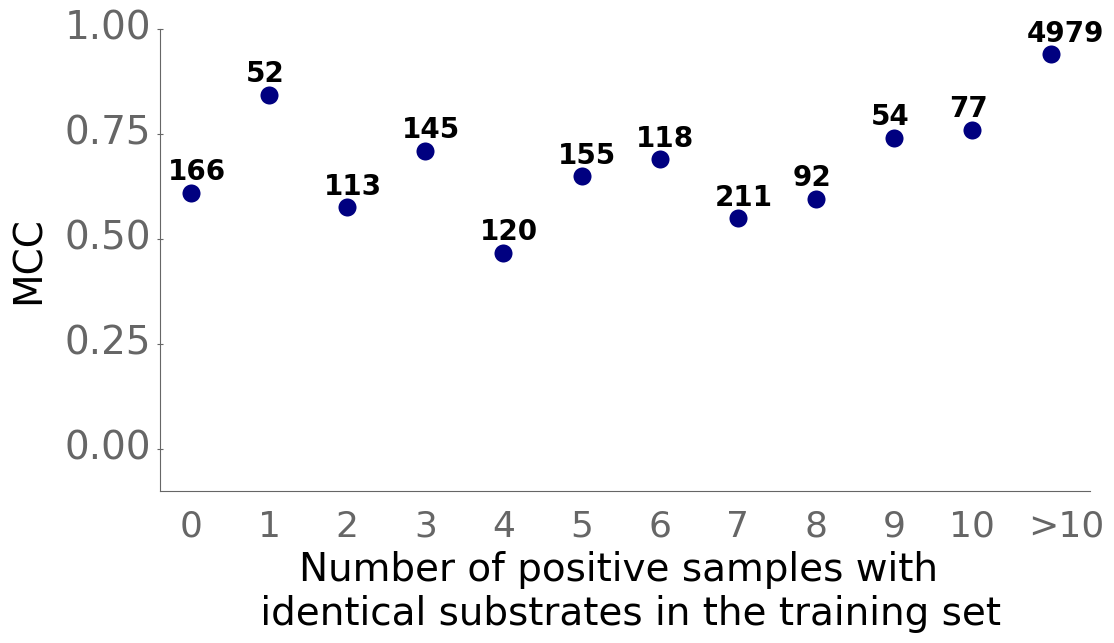

In [42]:
sub_bins = list(range(11))
MCCs = []
n_data_points = []
for k in sub_bins:
    df_help = data_test.loc[data_test["sub_train_count"] == k]
    pred = np.round(np.array(df_help["y_pred_ChemBERTa_ESM1b"]))
    true = np.array(df_help["outcome"])
    mcc = matthews_corrcoef(true, pred)
    MCCs.append(mcc)
    print(k, mcc, len(pred))
    n_data_points.append(len(pred))

df_help = data_test.loc[data_test["sub_train_count"] > 10]
pred = np.round(np.array(df_help["y_pred_ChemBERTa_ESM1b"]))
true = np.array(df_help["outcome"])
mcc = np.mean(pred == true)
n_data_points.append(len(pred))
print(">10", mcc, len(pred))
MCCs.append(mcc)
sub_bins.append(11)


plt.rcParams.update({'font.size': 28})

#plt.rc('font', **font)

fig, ax = plt.subplots(figsize= (12,6))
#plt.title("Distribution of predicted probabilities", fontsize= 30, y= 1)

#plt.bar(sub_bins, height = MCCs,  color= "navy")

for i in range(12):
    plt.scatter(i, MCCs[i], c='navy', marker="o", linewidths= 8, label ="KCATpred")
    ax.annotate(n_data_points[i], (i-0.3, MCCs[i]+0.03), fontsize=20, c= "black", weight = "bold")

plt.xlabel('Number of positive samples with \n identical substrates in the training set')
plt.ylabel('MCC')
ax.yaxis.set_label_coords(-0.12, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

ticks2 = np.array(list(range(11)) + [11.2])
labs = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", ">10"]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

plt.ylim((-0.1,1))
plt.xlim((-0.4,11.5))
plt.savefig(join("..", "..", "figures", "MCC_num_subs.png"))
plt.show()

0 0.8674698795180723 166
1 0.9423076923076923 52
2 0.8495575221238938 113
3 0.896551724137931 145
4 0.8 120
5 0.8774193548387097 155
6 0.8898305084745762 118
7 0.8436018957345972 211
8 0.8586956521739131 92
9 0.9074074074074074 54
10 0.9090909090909091 77
>10 0.9395460935930909 4979


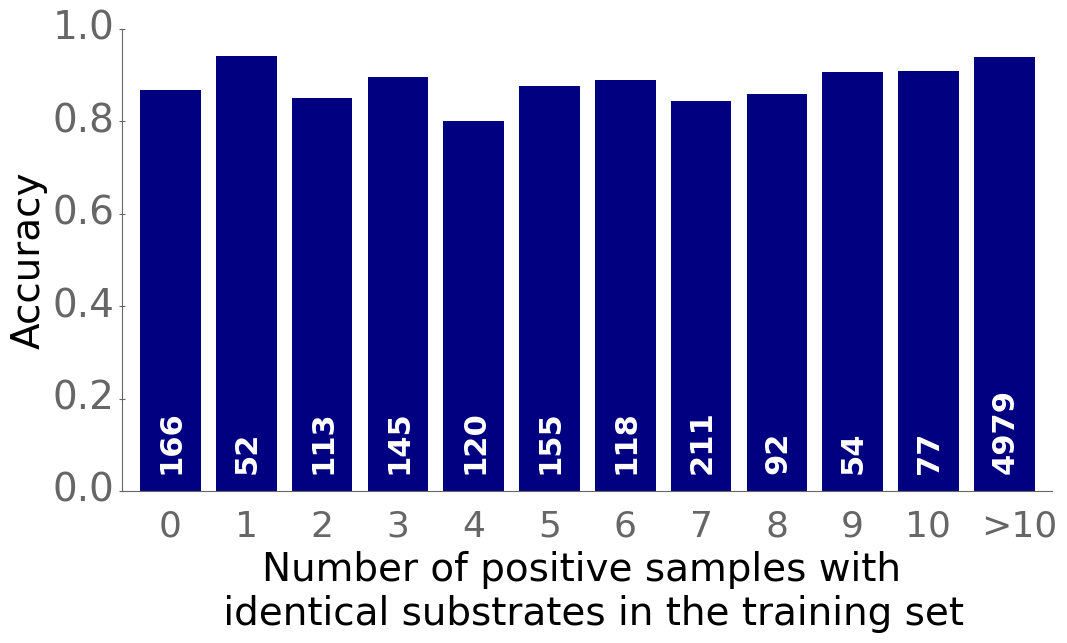

In [43]:
sub_bins = list(range(11))
MCCs = []
for k in sub_bins:
    df_help = data_test.loc[data_test["sub_train_count"] == k]
    pred = np.round(np.array(df_help["y_pred_ChemBERTa_ESM1b"]))
    true = np.array(df_help["outcome"])
    mcc = np.mean(true == pred)
    MCCs.append(mcc)
    print(k, mcc, len(pred))

df_help = data_test.loc[data_test["sub_train_count"] > 10]
pred = np.round(np.array(df_help["y_pred_ChemBERTa_ESM1b"]))
true = np.array(df_help["outcome"])
mcc = np.mean(pred == true)
print(">10", mcc, len(pred))
MCCs.append(mcc)
sub_bins.append(11)


plt.rcParams.update({'font.size': 28})

#plt.rc('font', **font)

fig, ax = plt.subplots(figsize= (12,6))
#plt.title("Distribution of predicted probabilities", fontsize= 30, y= 1)

plt.bar(sub_bins, height = MCCs,  color= "navy")

for i in range(12):
    if i ==0:
        ax.annotate(n_data_points[i], (i-0.18, 0.05), fontsize=22, c= "white", weight = "bold", rotation = 90)
    else:
        ax.annotate(n_data_points[i], (i-0.18, 0.05), fontsize=22, c= "white", weight = "bold", rotation = 90)

plt.xlabel('Number of positive samples with \n identical substrates in the training set')
plt.ylabel('Accuracy')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

ticks2 = np.array(list(range(11)) + [11.2])
labs = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", ">10"]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

plt.ylim((0,1))
plt.savefig(join("..", "..", "figures", "acc_num_subs.png"))
plt.show()

In [44]:
help_df = data_test.loc[data_test["sub_train_count"]> 0]

y_true = np.array(help_df["outcome"])
y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
acc =  np.mean(y_pred == np.array(y_true))
mcc = matthews_corrcoef(np.array(y_true), y_pred)

acc, mcc, len(y_pred)

(0.9264224983649444, 0.806391014443847, 6116)

In [45]:
help_df = data_test.loc[data_test["sub_train_count"] == 0]

y_true = np.array(help_df["outcome"])
y_pred = np.round(np.array(help_df["y_pred_ChemBERTa_ESM1b"]))
acc =  np.mean(y_pred == np.array(y_true))
mcc = matthews_corrcoef(np.array(y_true), y_pred)

acc, mcc, len(y_pred)

(0.8674698795180723, 0.6098277916439723, 166)

In [46]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(np.array(data_test["outcome"]), np.round(np.array(data_test["y_pred_ChemBERTa_ESM1b"]))).ravel()
print("True positive rate: %s" % (tp/(tp+fn)))
print("False positive rate: %s" % (fp/(tp+fn)))

True positive rate: 0.8240684178375076
False positive rate: 0.11240073304825901
